#### Вспомогательные действия с колабом

In [1]:
!pip install `nbconvert[webpdf]`

zsh:1: no matches found: nbconvert[webpdf]
ERROR: You must give at least one requirement to install (see "pip help install")


In [1]:
!pip install -q pyro-ppl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 17.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
folder = 'drive/My Drive/thesis/'

#### Импорты и загрузка данных

In [4]:
import os
import time
from collections import defaultdict
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image, ImageColor
from scipy.special import expit
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions.constraints as constraints
from torch import tensor
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchsummary import summary

import torchvision.datasets as dset
import torchvision.transforms as transforms
from torchvision import datasets

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import seaborn as sns
sns.set(palette='Set2', font_scale=1.3)

from IPython.display import clear_output

import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util  # patches torchvision
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.optim import Adam, SGD

# Pyro settings
pyro.set_rng_seed(0)
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)
USE_CUDA = torch.cuda.is_available()

### 1. Load Colored MNIST dataset

In [23]:
colors = [
        'darkgreen', '#6495ed', 'darkblue', '#b03060',
        'orangered', 'yellow', 'burlywood', 'lime',
        'aqua', 'fuchsia',
    ]
color_names = ['darkgreen', 'blue', 'darkblue', 'maroon', 'orangered',
            'yellow', 'burlywood', 'lime', 'aqua', 'fuchsia']
color_dict = {k: v for k, v in enumerate(color_names)}

def get_rgb(x):
    t = torch.tensor(ImageColor.getcolor(x, "RGB")) / 255.
    return t.view(-1, 1, 1)

NUM_COLORS = len(colors)
colors = list(map(get_rgb, colors))
COUNTERFACTUAL_LABELS = [0,2,4,6,8]

class DoubleColoredMNIST(Dataset):
    def __init__(self, train=True, counterfactual=False):
        self.train = train
        self.counterfactual = counterfactual
        self.mnist_sz = 28

        # get mnist
        if train:
            mnist = datasets.MNIST(root='data', download=True, train=True)
        else:
            mnist = datasets.MNIST(root='data', download=True, train=False)
        ims, labels = mnist.data, mnist.targets
        self.T = transforms.Compose([
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        if self.counterfactual:
            self.ims_digit = []
            self.labels = []
            for im, l in zip(torch.stack([ims, ims, ims], dim=1), labels):
                if l.item() in COUNTERFACTUAL_LABELS:
                    self.ims_digit.append(im)
                    self.labels.append(l)
            self.labels = np.array(self.labels)
        else:
            self.ims_digit = torch.stack([ims, ims, ims], dim=1)
            self.labels = labels

    def __getitem__(self, idx):
        digit = self.labels[idx]
        if self.train:
            if digit.item() in COUNTERFACTUAL_LABELS:
                fg_i = np.random.choice([i for i in range(NUM_COLORS) if i != digit])
                bg_i = np.random.choice([i for i in range(NUM_COLORS) if i not in [digit, (digit + 1) % NUM_COLORS, fg_i]])
            else:
                fg_i = np.random.choice(NUM_COLORS)
                bg_i = np.random.choice([i for i in range(NUM_COLORS) if i != fg_i])
        elif self.counterfactual:
            fg_i = int(digit)
            bg_i = int((digit + 1) % NUM_COLORS)
        else:
            fg_i = np.random.choice(NUM_COLORS)
            bg_i = np.random.choice([i for i in range(NUM_COLORS) if i != fg_i])
        back_color = colors[bg_i].clone()
        back_color += torch.normal(0, 1e-3, (3, 1, 1))
        obj_color = colors[fg_i].clone()
        obj_color += torch.normal(0, 1e-3, (3, 1, 1))

        # get digit
        im_digit = (self.ims_digit[idx] / 255.).to(torch.float32)
        im_digit = F.interpolate(im_digit[None,:], (self.mnist_sz, self.mnist_sz)).squeeze()
        im_digit = (im_digit > 0.1).to(int)  # binarize

        # plot digit onto the texture
        ims = im_digit * (obj_color) + (1 - im_digit) * back_color

        ret = {
            'img': self.T(ims),
            'label': np.array([digit, fg_i, bg_i], dtype=int),
        }
        return ret

    def __len__(self):
        return self.labels.shape[0]

In [24]:
LABEL_SIZES = [10, NUM_COLORS, NUM_COLORS]
LABEL_NAMES = ['digit', 'obj_color', 'bg_color']
dataset_train = DoubleColoredMNIST(train=True)
dataset_test = DoubleColoredMNIST(train=False)
dataset_counterfactual = DoubleColoredMNIST(train=False, counterfactual=True)
print(len(dataset_train), len(dataset_test), len(dataset_counterfactual))
print(LABEL_SIZES)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 12625013.97it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 343500.21it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3131064.17it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 6988455.16it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

60000 10000 4926
[10, 10, 10]


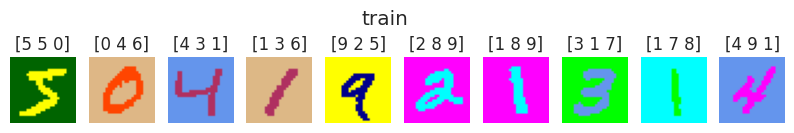

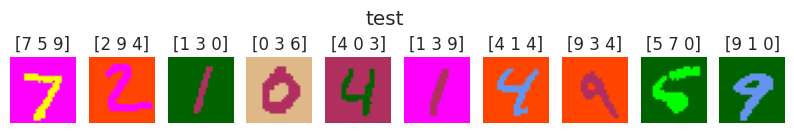

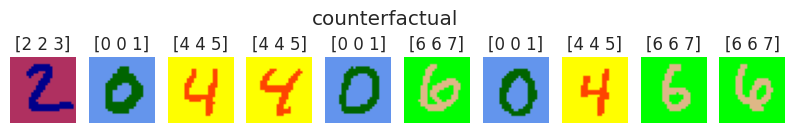

In [25]:
def normalize(img):
    a = np.expand_dims([0.5, 0.5, 0.5], (0,1))
    normalized = img * a + a
    return normalized.clip(0, 1)

for n, dataset in zip(['train', 'test', 'counterfactual'], [dataset_train, dataset_test, dataset_counterfactual]):
    plt.figure(figsize=(10, 2))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        sample = dataset[i]
        plt.imshow(normalize(sample['img'].permute(1, 2, 0)))
        plt.title(str(sample['label']))
        plt.axis('off')
    plt.suptitle(n, y=.9)
    plt.show()

In [26]:
BATCH_SIZE = 256
train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True)
cf_loader = DataLoader(dataset_counterfactual, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True)

#### Вспомогательные действия с колабом

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
folder = 'drive/My Drive/thesis/.../'

### 1. Реализация модели

Далее определим модули декодера и энкодера и общий класс обучения вариационного автоэнкодера.

Реализация декодера без изменений

In [8]:
class Decoder(nn.Module):
    ''' Реализация модели сверточного декодера. '''

    def __init__(self, y_dim, p=0.1):
        '''
        y_dim -- размерность скрытого пространства
        p -- параметр dropout
        '''

        super(Decoder, self).__init__()

        # Первый несверточный слой вынесем отдельно
        self.first_layer = nn.Linear(in_features=y_dim, out_features=64*7*7)

        self.layers = nn.Sequential(
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(),
            nn.Dropout(p=p),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.Upsample(size=(14, 14)),  # увеличиваем размер картинки
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(),
            nn.Dropout2d(p=p),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.Upsample(size=(28, 28)),  # увеличиваем размер картинки
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(),
            nn.Dropout2d(p=p),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(),
            nn.Dropout2d(p=p),
            nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # Предсказываем вероятности белого цвета для картинки
        )

    def forward(self, x):
        x = self.first_layer(x)
        x = x.view((-1, 64, 7, 7))  # из вектора получаем трехмерный тензор
        prob_output = self.layers(x)
        return prob_output

В реализации энкодера есть изменения — метку класса нельзя передать в сверточный слой, поэтому передаем ее в первый полносвязный.

In [9]:
class Encoder(nn.Module):
    ''' Реализация модели сверточного энкодера. '''

    def __init__(self, y_dim, label_dim=30, p=0.1):
        '''
        y_dim -- размерность скрытого пространства
        label_dim -- размерность метки класса
        p -- параметр dropout
        '''

        super(Encoder, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(),
            nn.Dropout2d(p=p),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(),
            nn.Dropout2d(p=p),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(),
            nn.Dropout2d(p=p),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(),
            nn.Flatten(),  # растягиваем тензор в вектор
            nn.Dropout(p=p)
        )

        # Полносвязные слои, отвечающие за среднее и дисперсию
        # точки в скрытом пространстве
        self.fc_output_loc = nn.Linear(in_features=3136+label_dim, out_features=y_dim)
        self.fc_output_scale = nn.Linear(in_features=3136+label_dim, out_features=y_dim)

    def forward(self, x, labels):
        hidden = self.layers(x)

        # Конкатенируем растянутый выход сверточных слоев с меткой
        hidden = torch.cat([hidden, labels], dim=1)

        # Считаем параметры распределения
        y_loc = self.fc_output_loc(hidden)
        y_scale = torch.exp(self.fc_output_scale(hidden))
        return y_loc, y_scale

Обратите внимание, что класс `VAE` использует Pyro-инструменты. Для обучения с помощью стохастического вариационного вывода с помощью класса `pyro.infer.SVI` вместо метода `forward` требуется определить методы `model` и `guide` (названия могут быть другими).

Также важно отметить, что в качестве наблюдений в `pyro.sample`, с заданным распределением `dist.Bernoulli` передаются дробные значения. Их можно понимать как "наблюдаемые" вероятности белого цвета. Это работает из-за отключенной валидации параметров распределениев. Такой соответствует рассмотрению кросс-энтропии вместо логарифма функции правдоподобия, или же среднему значению функции правдоподобия по "наблюдаемым" вероятностям.

In [61]:
class CVAE(nn.Module):
    ''' Реализация модели сверточного условного вариационного автоэнкодера. '''

    def __init__(self, y_dim=2, label_dim=30, p=0.2, use_cuda=False):
        '''
        y_dim -- размерность скрытого пространства
        p -- параметр dropout
        use_cuda -- использовать ли cuda
        '''

        super().__init__()

        # Объявляем энкодер и декодер
        self.encoder_ = Encoder(y_dim, label_dim=label_dim, p=p)
        self.decoder_ = Decoder(y_dim+label_dim, p=p)

        if use_cuda:
            self.cuda()

        self.use_cuda = use_cuda
        self.y_dim = y_dim
        self.label_dim = label_dim

    def get_one_hot(self, labels):
        new_ys = []
        for i, label_length in enumerate(LABEL_SIZES):
            new_y = nn.functional.one_hot(labels[:, i].to(torch.int64), int(label_length))
            new_ys.append(new_y)
        new_ys = torch.cat(new_ys, -1)
        return new_ys.to(torch.float32)

    def model(self, x, labels):
        '''
        Метод, определяющий совместное распределение (X, Y) с помощью
        априорного распределения Y и распределения X|Y.
        Величина X является наблюдаемой и передается как x.
        '''

        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()

        # регистрируем PyTorch-модуль в Pyro
        pyro.module("decoder", self.decoder_)

        with pyro.plate("data", x.shape[0]):
            # гиперпараметры априорного распределения
            y_loc = x.new_zeros(torch.Size((x.shape[0], self.y_dim)))
            y_scale = x.new_ones(torch.Size((x.shape[0], self.y_dim)))

            # Cемпл из априорного распределения.
            # На самом же деле при вычислении ELBO значение будет семплироваться в guide.
            y = pyro.sample("latent", dist.Normal(y_loc, y_scale).to_event(1))

            # Декодируем значение из скрытого пространства,
            # сконкатенированного с one-hot меткой класса
            loc_img = self.decoder_(torch.cat([y, self.get_one_hot(labels)], dim=1))
            # loc_img = self.decoder_(
            #     torch.cat([y, nn.functional.one_hot(labels, num_classes=self.label_dim)], dim=1)
            # )

            # Определим условность, сказав, что наблюдение определяют две последних размерности.
            # В качестве наблюдений передаются дробные значения, типа вероятности белого цвета.
            # Это работает из-за отключенной валидации параметров распределениев.
            pyro.sample(
                "obs",
                dist.Bernoulli(loc_img.squeeze()).to_event(3),
                obs=x.squeeze()
            )

    def guide(self, x, labels):
        '''
        Метод, определяющий вариационное распределение Y используя при этом X.
        '''

        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()

        # регистрируем PyTorch-модуль в Pyro
        pyro.module("encoder", self.encoder_)

        with pyro.plate("data", x.shape[0]):
            # Кодируем изображение в значения из скрытого пространства,
            # передавая также one-hot метку класса
            y_loc, y_scale = self.encoder_(x, self.get_one_hot(labels))
            # y_loc, y_scale = self.encoder_(
            #     x, nn.functional.one_hot(labels, num_classes=self.label_dim)
            # )

            # Семплируем значения из скрытого пространства
            pyro.sample("latent", dist.Normal(y_loc, y_scale).to_event(1))

    def encoder(self, x, labels, return_cpu=True):
        ''' Обертка над энкодером, выполняющая работу по переводу тензоров между CPU и GPU '''

        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()

        y_one_hot = self.get_one_hot(labels)
        y_loc, y_scale = self.encoder_(x, y_one_hot)

        # y_loc, y_scale = self.encoder_(
        #     x, nn.functional.one_hot(labels, num_classes=self.label_dim)
        # )

        if self.use_cuda and return_cpu:
            y_loc = y_loc.cpu()
            y_scale = y_scale.cpu()
        return y_loc, y_scale

    def decoder(self, y, labels, return_cpu=True):
        ''' Обертка над декодером, выполняющая работу по переводу тензоров между CPU и GPU '''

        if self.use_cuda:
            y = y.cuda()
            labels = labels.cuda()

        y_one_hot = self.get_one_hot(labels)
        loc_img = self.decoder_(torch.cat([y, y_one_hot], dim=1))
        # loc_img = self.decoder_(
        #     torch.cat([y, nn.functional.one_hot(labels, num_classes=self.label_dim)], dim=1)
        # )

        if self.use_cuda and return_cpu:
            loc_img = loc_img.cpu()
        return loc_img

    def reconstruct_img(self, x, labels, return_cpu=True):
        ''' Прогоняет картинку через всю сеть и выполняет работу по переводу тензоров между CPU и GPU '''

        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()

        # Кодируем полученные изображения с метками, получая распределение в скрытом пространстве
        y_one_hot = self.get_one_hot(labels)
        y_loc, y_scale = self.encoder_(
            x, y_one_hot
        )
        # Cэмплируем точки в скрытом пространстве
        y = dist.Normal(y_loc, y_scale).sample()
        # Восстанавливаем соответствующее им и меткам изображение
        y_one_hot = self.get_one_hot(labels)

        loc_img = self.decoder_(
            torch.cat([y, y_one_hot], dim=1)
        )

        if self.use_cuda and return_cpu:
            loc_img = loc_img.cpu()
        return loc_img

Определим также функции одной эпохи обучения модели и вычисления лосса на тестовом множестве.

In [11]:
def train(svi, train_loader, use_cuda=False):
    ''' Реализация одной эпохи обучения модели. '''

    epoch_loss = 0.
    for batch in train_loader:
        x, l = batch['img'], batch['label']
        # мини-батч шаги 2-SVI
        epoch_loss += svi.step(x, l)

    # Номируем лосс на количество обучающих данных
    total_epoch_loss_train = epoch_loss / len(train_loader.dataset)
    return total_epoch_loss_train

In [12]:
def evaluate(svi, test_loader, use_cuda=False):
    ''' Оценка лосса на тестовом множестве. '''

    test_loss = 0.
    for batch in test_loader:
        x, l = batch['img'], batch['label']
        # Считаем лосс по батчам
        test_loss += svi.evaluate_loss(x, l)

    # Номируем лосс на количество данных
    total_epoch_loss_test = test_loss / len(test_loader.dataset)
    return total_epoch_loss_test

Функция отрисовки текущего статуса обучения.    

In [13]:
def callback(train_elbo, test_elbo, test_epoch_num, epoch):
    '''
    Отрисовка текущего статуса обучения.
    '''

    # Отложенная очистка экрана
    clear_output(wait=True)

    # Объявление фигуры и сетки
    plt.figure(figsize=(10, 4), constrained_layout=False)
    plt.plot(range(1, len(train_elbo)+1), train_elbo, lw=2, color='#00CC66', label='train')
    plt.plot(test_epoch_num, test_elbo, lw=2, color='#FF3300', label='test')
    plt.legend()
    plt.xlabel('Номер эпохи')
    plt.title(f'Эпоха {epoch}. ELBO')
    plt.show()

### 2. Обучение модели, двумерное скрытое пространство

Определяем опции обучения

In [14]:
LEARNING_RATE = 5.0e-4
NUM_EPOCHS = 500
TEST_FREQUENCY = 1  # кол-во эпох, через которые оценивать лосс на тесте

Определяем модель и класс стохастического вариационного вывода

In [16]:
# Очищаем хранилище параметров
pyro.clear_param_store()

# Модель CVAE
vae = CVAE(y_dim=30, use_cuda=USE_CUDA)

# Модель VAE
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# Класс вариационного вывода
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

Обучение модели с помощью стохастического вариационного вывода

In [17]:
TEST_FREQUENCY = 5

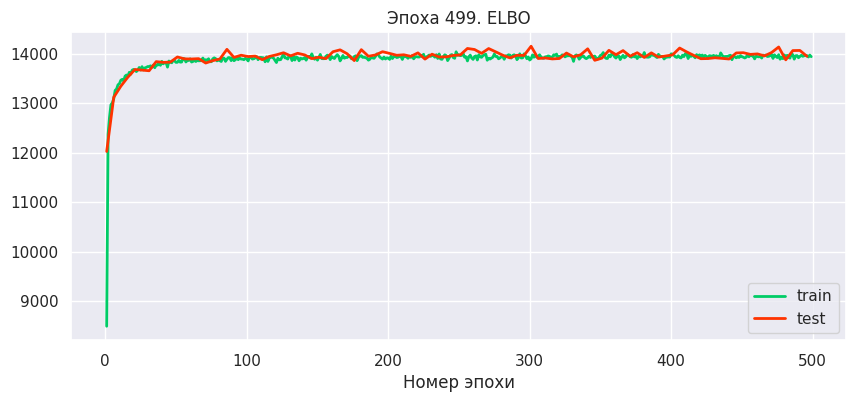

{'lr': 3.828679769178445e-15}


In [ ]:
train_elbo = []
test_elbo = []
test_epoch_num = []

for epoch in range(NUM_EPOCHS):
    # Совершаем одну эпоху обучения
    print(optimizer.pt_optim_args)
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    # Сохраняем лосс
    train_elbo.append(-total_epoch_loss_train)

    # Считаем лосс на тесте
    if epoch % TEST_FREQUENCY == 0:
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        test_epoch_num.append(epoch+1)
        torch.save(vae.state_dict(), '/content/drive/MyDrive/vae_06_11_zdim30.pth')

    # Визуализация
    callback(train_elbo, test_elbo, test_epoch_num, epoch+1)
    optimizer.pt_optim_args['lr'] *= 0.95

### 5. Анализ модели применительно к генеративному моделированию


Отключим режим обучения

In [62]:
Z_DIM = 30
pyro.clear_param_store()
vae = CVAE(y_dim=Z_DIM, use_cuda=USE_CUDA)
vae.load_state_dict(torch.load('/content/vae_06_11_zdim30.pth',
                               map_location='cuda' if USE_CUDA else 'cpu'))
vae.train(False);

In [63]:
import torchvision.utils as vutils

DIGIT: 0


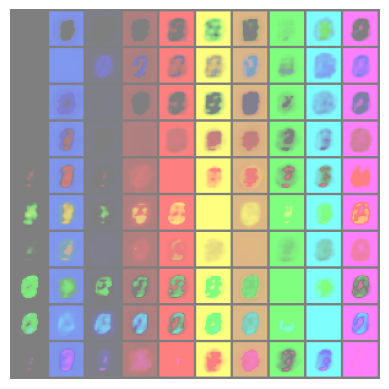

DIGIT: 1


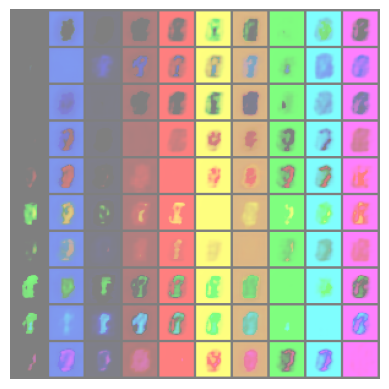

DIGIT: 2


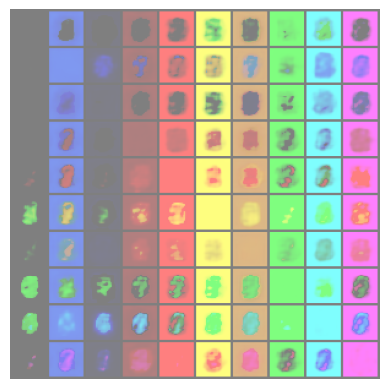

DIGIT: 3


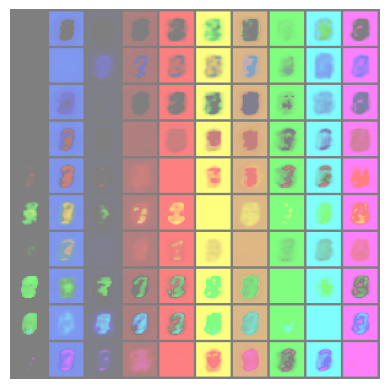

DIGIT: 4


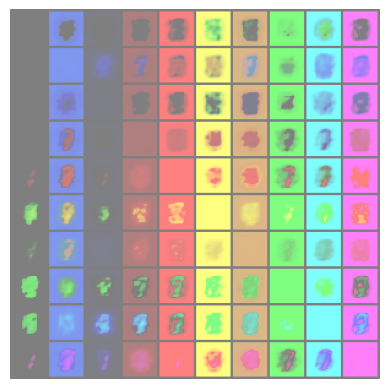

DIGIT: 5


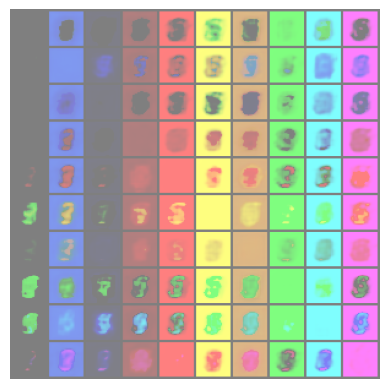

DIGIT: 6


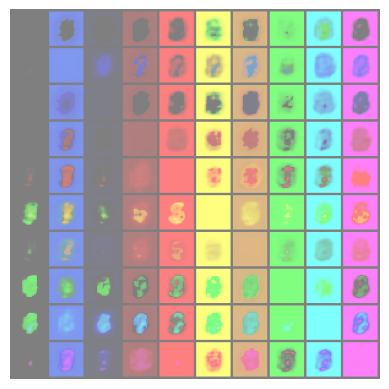

DIGIT: 7


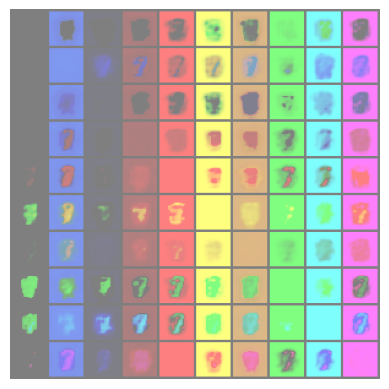

DIGIT: 8


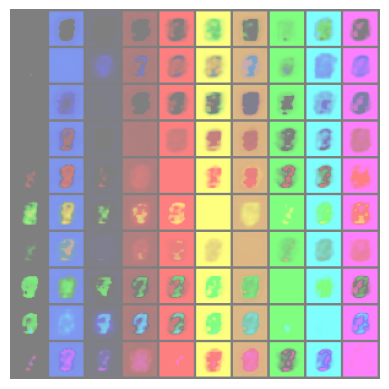

DIGIT: 9


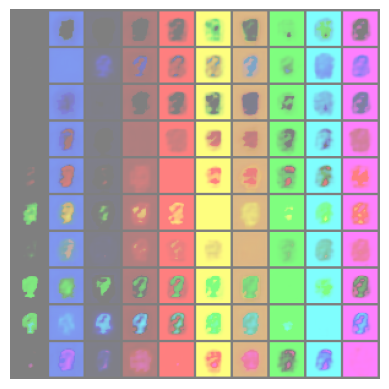

In [47]:
for digit in range(10):
    print('DIGIT:', digit)
    img_block = []
    for fg_color in range(10):
        img_row = []
        for bg_color in range(10):
            zs = dist.Normal(torch.zeros(Z_DIM), torch.ones(Z_DIM) * 0.01).sample().unsqueeze(0)
            ys = torch.tensor([digit, fg_color, bg_color]).unsqueeze(0)
            xs = vae.decoder(zs, ys).detach() # 1, 3, 28, 28

            img_row.append(xs)
        img_block.append(torch.concat(img_row, dim=0))

    img_block = torch.stack(img_block, dim=0)
    grid = vutils.make_grid(img_block.flatten(end_dim=1), nrow=10, padding=2)
    plt.imshow(normalize(grid.permute(1,2,0)))
    plt.axis('off')
    plt.show()

Посмотрим на качество преобразуемых картин

In [64]:
def show_reconstructions(vae, loader, cols=5, rows=1):
    for k, batch in enumerate(loader):
        if k >= rows:
            return
        x = batch['img']
        l = batch['label']
        plt.figure(figsize=(1.5 * cols, 3))
        for i in range(cols):
            plt.subplot(2, cols, i+1)
            plt.imshow(normalize(x[i].permute(1, 2, 0)))
            plt.axis('off')
            plt.subplot(2, cols, i+cols+1)
            rec_img = vae.reconstruct_img(x[i:i+1], l[i:i+1]).squeeze().detach().numpy().transpose((1, 2, 0))
            plt.imshow(normalize(rec_img))
            plt.axis('off')
        plt.tight_layout()

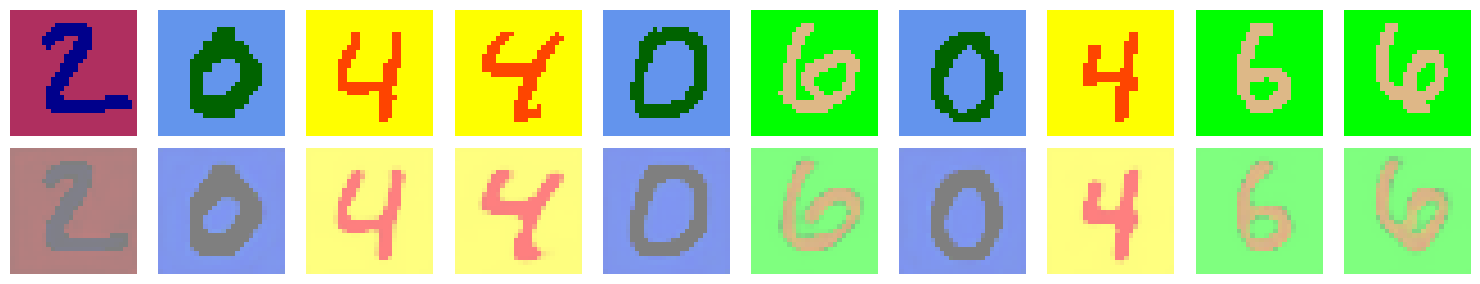

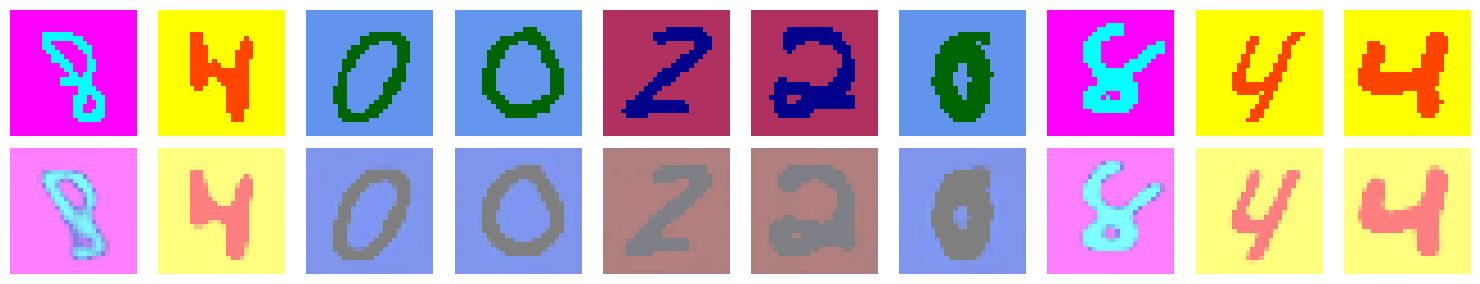

In [65]:
show_reconstructions(vae, cf_loader, 10, 2);

## СТАРОЕ (оригинал)

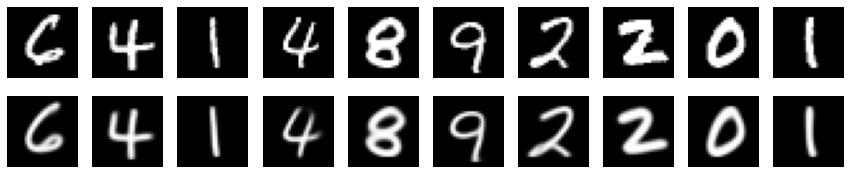

In [ ]:
# Посмотрим на качество преобразуемых картинfor x, l in test_loader:
    plt.figure(figsize=(15, 3))
    for i in range(10):
        plt.subplot(2, 10, i+1)
        plt.imshow(x[i, 0], cmap='gray')
        plt.axis('off')
        plt.subplot(2, 10, i+11)
        plt.imshow(vae.reconstruct_img(x[i:i+1], l[i:i+1]).squeeze().detach().numpy(), cmap='gray')
        plt.axis('off')
    break

Попробуем сгенерировать новые изображения цифр, сгенерировав 75 точек из скрытого пространства из распределения $\mathcal{N}(0, I_2)$. Далее для подачи на вход декодеру ко всем этом уже зафиксированным 75 точкам будет присоединять метку класса.

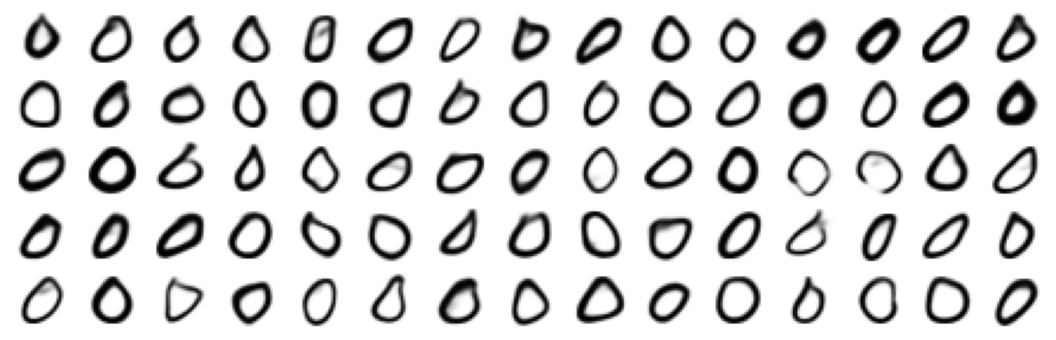

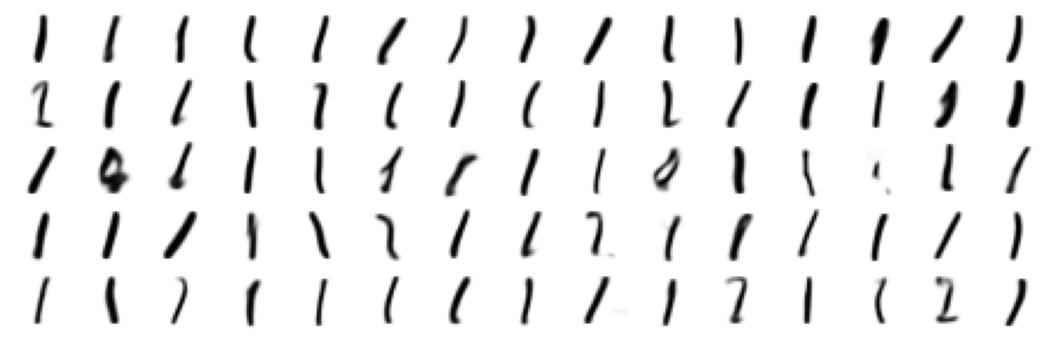

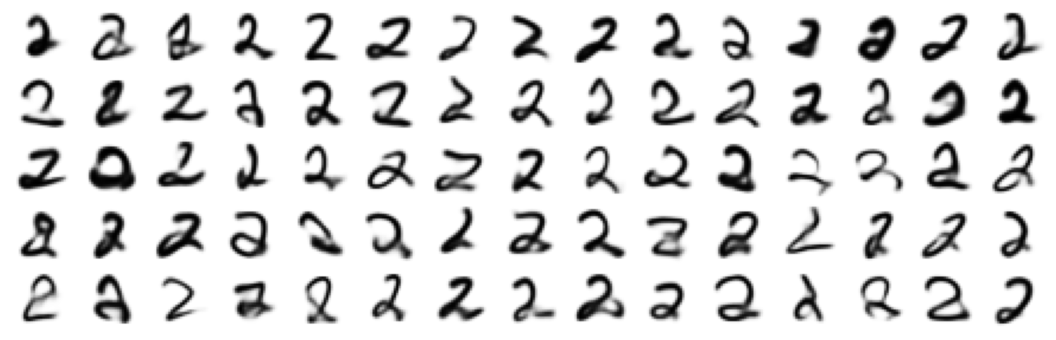

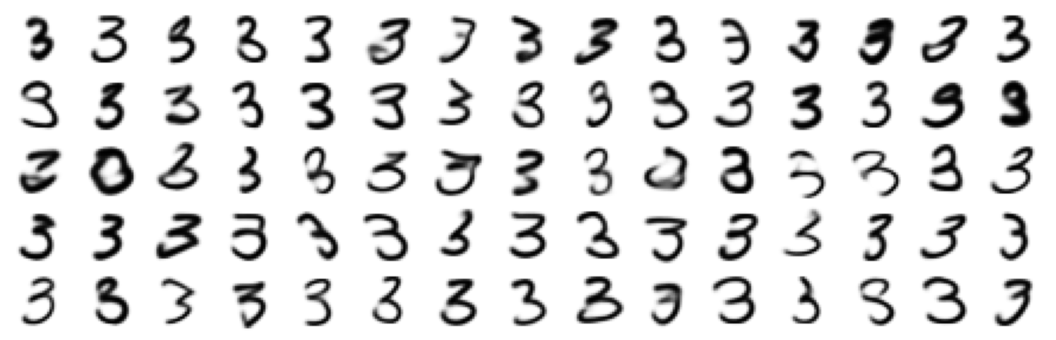

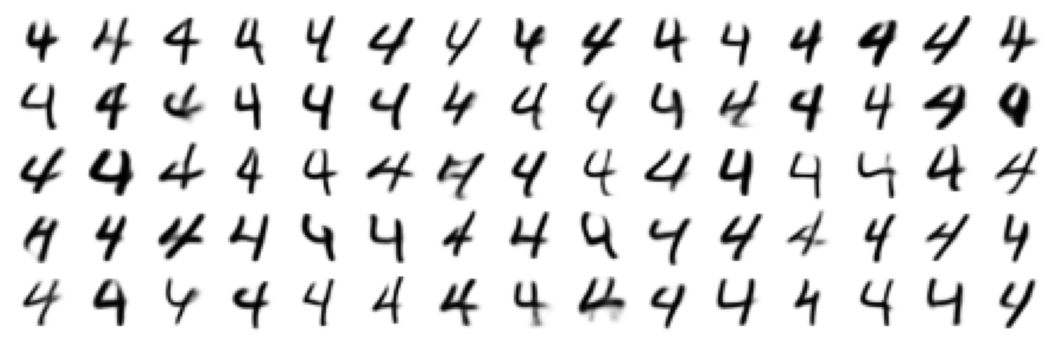

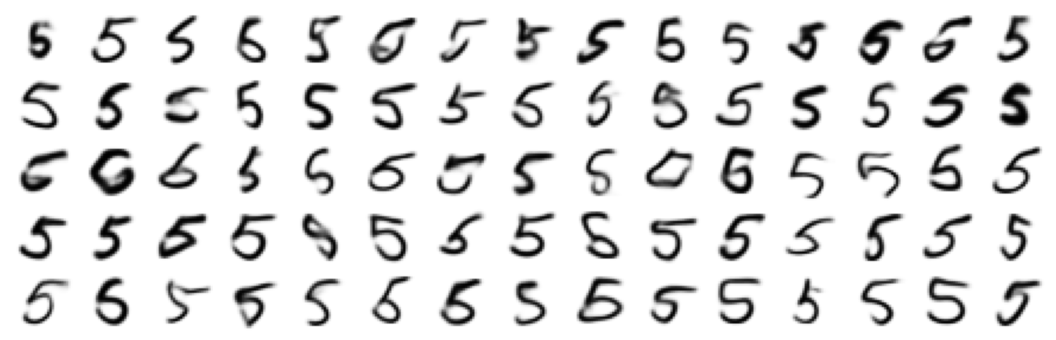

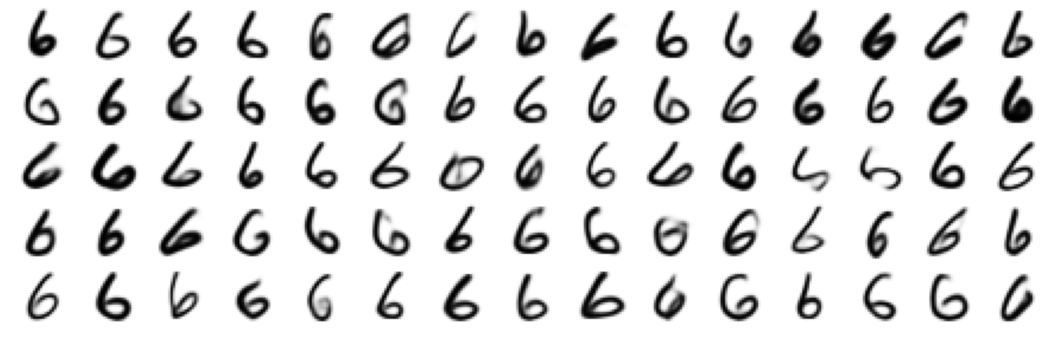

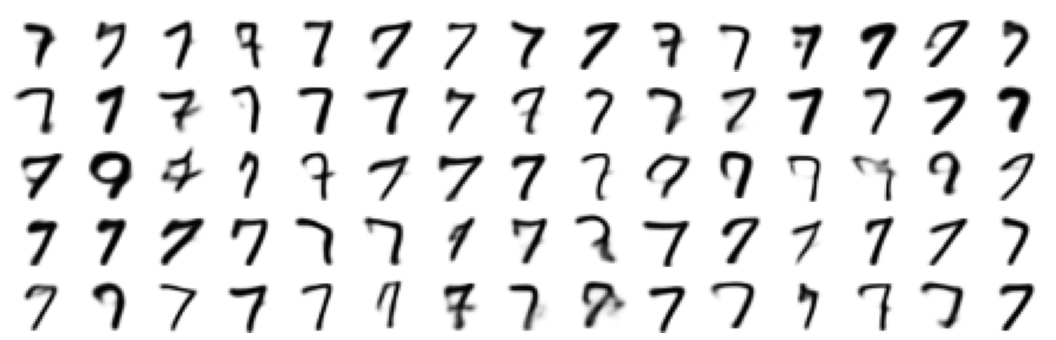

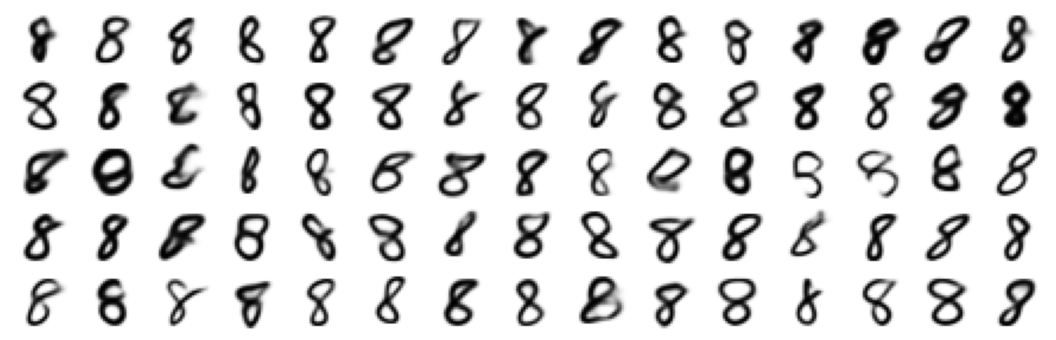

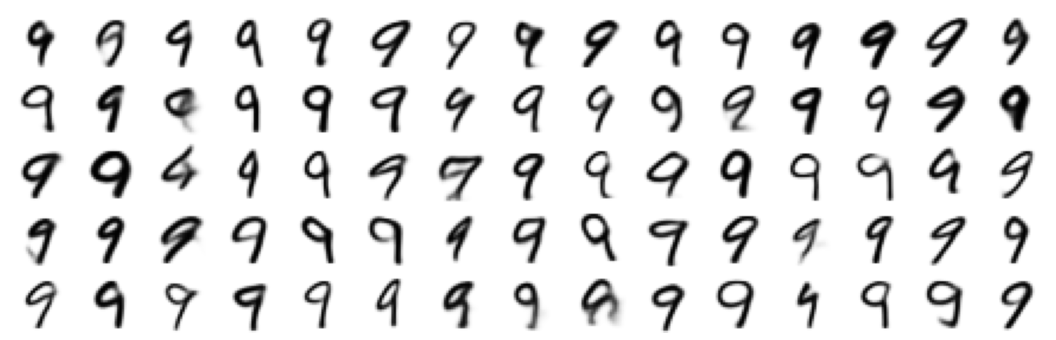

In [ ]:
n_test = 75

# Семплируем из скрытого пространства
y_loc = torch.zeros(torch.Size(( n_test, vae.y_dim)))
y_scale = torch.ones(torch.Size((n_test, vae.y_dim)))
y = dist.Normal(y_loc, y_scale).rsample()

# Для каждого класса
for j in range(10):
    # Метки этого класса
    labels = torch.zeros(n_test, dtype=int) + j
    # Получаем изображение
    loc_img = vae.decoder(y, labels)

    # Визуализация
    plt.figure(figsize=(15, 5))
    for i in range(n_test):
        plt.subplot(5, 15, i+1)
        plt.imshow(1-loc_img[i].squeeze().detach().numpy(), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.subplots_adjust(wspace=-0.01, hspace=-0.01)
    plt.savefig(folder+f'gen_30_{j}.png', dpi=200)

Можно заметить, что стили цифр разных классов, стоящих на одних и тех же местах довольно сильно похожи.

### 6. Трансфер стиля

Модель CVAE дает интересную возможность трансфера стиля.

Возьмем из теста изображение первых 10 семерок и получим для них точку в скрытом пространстве. Далее давайте перед подачей в декодер подменим лэйбл этой точки. На выходе мы получим то, какая могла бы быть цифра другого класса с таким же стилем.

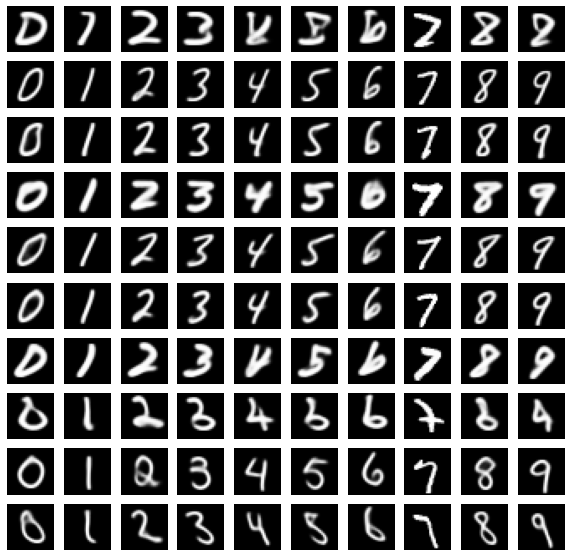

In [ ]:
plt.figure(figsize=(10, 10))

count = 0
for x, l in test_loader:
    for i in range(len(x)):
        if l[i] != 7: continue

        # Кодируем цифру с исходной меткой
        y = vae.encoder(x[i:i+1], l[i:i+1])[0]

        # Для каждого класса
        for j in range(10):
            # если исходная метка, то просто берем изображение
            if j == 7:
                img = x[i, 0]
            # иначе подменяем метку и прогоняем через декодер
            else:
                img = vae.decoder(y, torch.tensor([j])).squeeze()

            # Визуализация
            plt.subplot(10, 10, count*10+j+1)
            plt.imshow(img.detach().numpy(), cmap='gray')
            plt.axis('off')

        count += 1
        if count >= 10: break
    if count >= 10: break

Также эта особенность модели позволяет делать плавное преобразование одной цифры в другую.

Напечатаем несколько первых цифр из теста и их индексы.

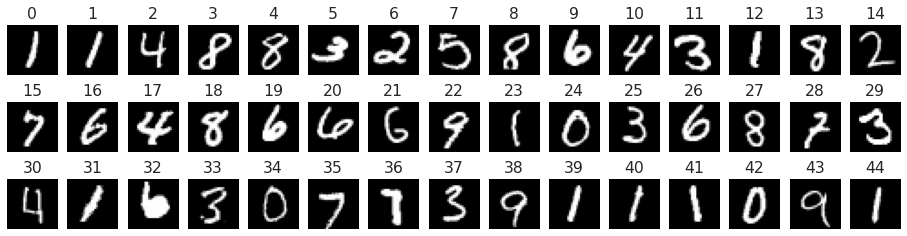

In [ ]:
plt.figure(figsize=(16, 4))
for i in range(45):
    plt.subplot(3, 15, i+1)
    plt.imshow(x[i, 0], cmap='gray')
    plt.title(i)
    plt.axis('off')

In [ ]:
def transformation(x1, x2, l, count=10):
    '''
    Создает отрезок по сетке из count точек
    между изображениями x1 и x2 с меткой l.
    '''

    # Кодируем оба изображения
    y1 = vae.encoder(x1.unsqueeze(0), l)[0]
    y2 = vae.encoder(x2.unsqueeze(0), l)[0]

    # Сетка точек на отрезке [0, 1]
    grid = torch.linspace(0, 1, count).reshape((count, 1))

    # Проводим отрезок между изображениями в скрытом пространстве
    line = y1 + (y2-y1) * grid

    # Декодируем этот отрезок в исходное пространство
    images = vae.decoder(line, torch.zeros(count, dtype=int) + l)

    return images.squeeze()

def draw_images(images):
    ''' Визуализация набора изображений. '''

    plt.figure(figsize=(len(images), 1))
    for i in range(len(images)):
        plt.subplot(1, len(images), i+1)
        plt.imshow(images[i].detach().numpy(), cmap='gray')
        plt.axis('off')

Посмотрим, как работают преобразования

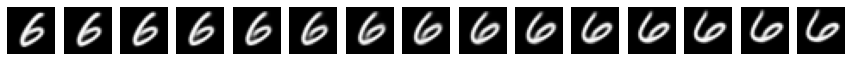

In [ ]:
images = transformation(x[16], x[20], torch.tensor([6]), count=15)
draw_images(images)

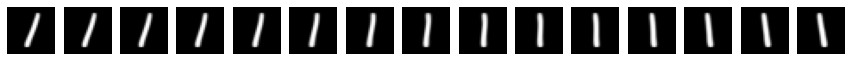

In [ ]:
images = transformation(x[1], x[41], torch.tensor([1]), count=15)
draw_images(images)

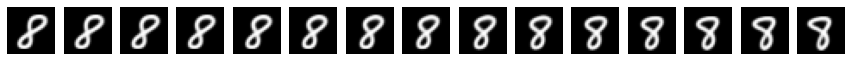

In [ ]:
images = transformation(x[3], x[13], torch.tensor([8]), count=15)
draw_images(images)

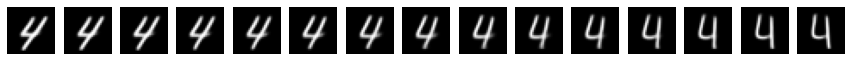

In [ ]:
images = transformation(x[10], x[30], torch.tensor([4]), count=15)
draw_images(images)

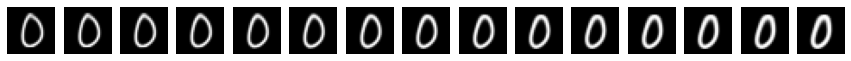

In [ ]:
images = transformation(x[34], x[42], torch.tensor([0]), count=15)
draw_images(images)

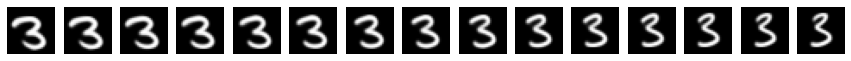

In [ ]:
images = transformation(x[11], x[37], torch.tensor([3]), count=15)
draw_images(images)

Отметим, что все это нелинейные преобразования в исходном пространстве.

Если мы попытаемся сделать линейное преобразование в исходном пространстве, то получим что-то такое:

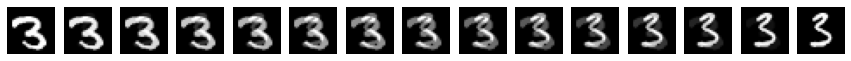

In [ ]:
grid = torch.linspace(0, 1, 15).reshape((15, 1, 1))
images = x[11, 0] + (x[37, 0] - x[11, 0]) * grid
draw_images(images)

----------------------------

### 7. Загрузка ранее обученной модели

Сохраним обученную на Колабе модель:

In [ ]:
torch.save(vae, folder+'cvae.model')

Можем теперь загрузить ее локально. Перед запуском этой ячейки должны быть выполнены ячейки, в которых объявлен класс и вспомогательные функции.

In [ ]:
vae_load = torch.load(folder+'cvae.model', map_location=torch.device('cpu'))
vae_load.use_cuda = False

Загрузим свою цифру и посмотрим на ее преобразование через VAE

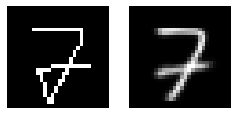

In [ ]:
img = plt.imread(folder+'katya.png').mean(axis=2)
plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.axis('off');
plt.subplot(1, 2, 2)
plt.imshow(vae.reconstruct_img(torch.tensor(img).unsqueeze(0).unsqueeze(0),
                               torch.tensor([7])).squeeze().detach().numpy(), cmap='gray')
plt.axis('off');

Попробуем сгенерировать 10 случайных цифр в таком же стиле

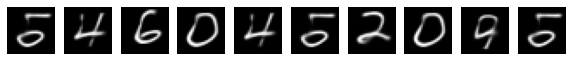

In [ ]:
count = 10

image = torch.tensor(img).unsqueeze(0).unsqueeze(0)
label = torch.tensor([7])
y = vae.encoder(image, label)[0]
labels = dist.Categorical(torch.tensor([0.1]*10)).sample([count]).squeeze()
images = vae.decoder(torch.repeat_interleave(y, count, dim=0), labels)

draw_images(images.squeeze())

И еще раз

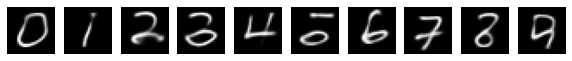

In [ ]:
image = torch.tensor(img).unsqueeze(0).unsqueeze(0)
label = torch.tensor([7])
y = vae.encoder(image, label)[0]
y = torch.repeat_interleave(y, count, dim=0)
y += dist.Normal(loc=0, scale=0.5).rsample(y.shape)
labels = torch.arange(0, 10)
images = vae.decoder(y, labels)

draw_images(images.squeeze())